# Bay Area Rapid Transit (BART) Project

![Bart System](https://www.bart.gov/sites/default/files/2025-01/BART-system-map-everyday-until-9pm.png)

Bu projede BART Hattına ait transfer verilerine dayanarak aşağıdaki sorulara yanıt aranacaktır:

* Veri Analitiği Soruları
	1. En yoğun BART istasyonu hangisidir?
	2. En az popüler olan BART rotası hangisidir?
	3. Bir koltuk bulmak istiyorsanız Berkeley'den SF'ye gitmek için en iyi zaman ne zamandır?
	4. Haftanın en yoğun günü hangisidir?
	5. Kaç kişi gece geç saatlerde BART'a biniyor?
* Veri Bilimi Soruları
	1. Soru A: Her istasyon arasındaki düz çizgi mesafesini hesaplayın
	2. Soru B: Bart'ın herhangi 2 istasyon arasında işe gidip gelen kişi sayısını tahmin edebilecek bir model oluşturun:
		- Buna nasıl yaklaşırsınız?
		- Hangi ek verilere ihtiyacınız olacak?
		- Şehir veya Bart yetkililerinin verilerinizi nasıl kullanmasını istersiniz?

### Veri Önişleme

In [1]:
import pandas as pd
pd.set_option("display.max_columns",100)

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import numpy as np

In [2]:
# Ödevde 2016 ve 2017 isteniyor ama ben son iki yılı almayı tercih ettim
df22=pd.read_csv("date-hour-soo-dest-2022.csv")
df23=pd.read_csv("date-hour-soo-dest-2023.csv")

In [3]:
df22.shape, df23.shape, 

((8245370, 5), (2815982, 5))

In [4]:
df=pd.concat([df22, df23])

In [5]:
df.shape

(11061352, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11061352 entries, 0 to 2815981
Data columns (total 5 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   Date                 object
 1   Hour                 int64 
 2   Origin Station       object
 3   Destination Station  object
 4   Trip Count           int64 
dtypes: int64(2), object(3)
memory usage: 506.3+ MB


In [7]:
df.isnull().sum()

Date                   0
Hour                   0
Origin Station         0
Destination Station    0
Trip Count             0
dtype: int64

In [8]:
df.head()

,Date,Hour,Origin Station,Destination Station,Trip Count
0,2022-01-01,0,12TH,12TH,1
1,2022-01-01,0,12TH,16TH,1
2,2022-01-01,0,12TH,24TH,2
3,2022-01-01,0,12TH,ASHB,1
4,2022-01-01,0,12TH,MONT,1


In [9]:
df.sort_values("Trip Count", ascending=False).head()

,Date,Hour,Origin Station,Destination Station,Trip Count
3723516,2022-06-20,14,POWL,DALY,493
4810178,2022-08-06,20,COLS,DUBL,480
3719518,2022-06-20,11,MLBR,POWL,453
3719274,2022-06-20,11,DUBL,MONT,405
3717978,2022-06-20,10,DALY,POWL,398


In [10]:
df["Origin Station"].unique()

array(['12TH', '16TH', '19TH', '24TH', 'ANTC', 'ASHB', 'BALB', 'BAYF',
       'CAST', 'CIVC', 'COLM', 'COLS', 'DALY', 'DBRK', 'DELN', 'DUBL',
       'EMBR', 'FRMT', 'FTVL', 'GLEN', 'HAYW', 'LAFY', 'LAKE', 'MCAR',
       'MLBR', 'MLPT', 'MONT', 'NBRK', 'OAKL', 'ORIN', 'PCTR', 'PHIL',
       'PITT', 'PLZA', 'POWL', 'RICH', 'ROCK', 'SANL', 'SBRN', 'SFIA',
       'SSAN', 'UCTY', 'WARM', 'WCRK', 'WOAK', 'BERY', 'CONC', 'NCON',
       'SHAY', 'WDUB'], dtype=object)

In [11]:
# Kalkış ve varış olarak aynı istasyon olan kayıtlar var. Bunları çıkaralım.
df=df[df['Origin Station'] != df['Destination Station']]

In [12]:
# İstasyon konumlarına bakalım
dfs=pd.read_csv("bart_stations.csv")

In [13]:
dfs.head()

,name,id,abbr,gtfs_latitude,gtfs_longitude,address,city,county,state,zipcode
0,12th St. Oakland City Center,12,12TH,37.803664,-122.271604,1245 Broadway,Oakland,alameda,CA,94612
1,16th St. Mission,16,16TH,37.765062,-122.419694,2000 Mission Street,San Francisco,sanfrancisco,CA,94110
2,19th St. Oakland,19,19TH,37.807870,-122.269029,1900 Broadway,Oakland,alameda,CA,94612
3,24th St. Mission,24,24TH,37.752254,-122.418466,2800 Mission Street,San Francisco,sanfrancisco,CA,94110
4,Ashby,AS,ASHB,37.853024,-122.269780,3100 Adeline Street,Berkeley,alameda,CA,94703


In [14]:
# İstasyon bilgilerini eklemek için sütunları oluşturma
new_columns = ['Origin Name', 'Origin Latitude', 'Origin Longitude', 'Destination Name', 'Destination Latitude', 'Destination Longitude']

# Kalkış istasyonu için sütunları ekleme
df = df.merge(dfs[['abbr', 'name', 'gtfs_latitude', 'gtfs_longitude']], left_on='Origin Station', right_on='abbr', how='left')
df = df.rename(columns={'name': 'Origin Name', 'gtfs_latitude': 'Origin Latitude', 'gtfs_longitude': 'Origin Longitude'})

# Varış istasyonu için sütunları ekleme
df = df.merge(dfs[['abbr', 'name', 'gtfs_latitude', 'gtfs_longitude']], left_on='Destination Station', right_on='abbr', how='left')
df = df.rename(columns={'name': 'Destination Name', 'gtfs_latitude': 'Destination Latitude', 'gtfs_longitude': 'Destination Longitude'})

# Gereksiz sütunları ve birleştirme için kullanılan abbr sütunlarını kaldırma
df = df.drop(columns=['abbr_x', 'abbr_y'])

In [15]:
df.head()

,Date,Hour,Origin Station,Destination Station,Trip Count,Origin Name,Origin Latitude,Origin Longitude,Destination Name,Destination Latitude,Destination Longitude
0,2022-01-01,0,12TH,16TH,1,12th St. Oakland City Center,37.803664,-122.271604,16th St. Mission,37.765062,-122.419694
1,2022-01-01,0,12TH,24TH,2,12th St. Oakland City Center,37.803664,-122.271604,24th St. Mission,37.752254,-122.418466
2,2022-01-01,0,12TH,ASHB,1,12th St. Oakland City Center,37.803664,-122.271604,Ashby,37.853024,-122.269780
3,2022-01-01,0,12TH,MONT,1,12th St. Oakland City Center,37.803664,-122.271604,Montgomery St.,37.789256,-122.401407
4,2022-01-01,0,12TH,POWL,2,12th St. Oakland City Center,37.803664,-122.271604,Powell St.,37.784991,-122.406857


## Veri Analitiği Soruları

#### <font color=red>En yoğun BART istasyonu hangisidir?</font>

In [16]:
dfO=df.groupby("Origin Name").agg({"Trip Count": [np.size, np.sum, np.mean]})
dfO.sort_values(("Trip Count", "mean"), ascending=False).head()

Trip Count                    
                            size      sum       mean
Origin Name                                         
Embarcadero               386194  4647233  12.033416
Powell St.                407825  4808515  11.790633
Montgomery St.            367212  3729558  10.156416
Civic Center/UN Plaza     381057  3294533   8.645775
24th St. Mission          306540  1971200   6.430482

In [17]:
dfD=df.groupby("Destination Name").agg({"Trip Count": [np.size, np.sum, np.mean]})
dfD.sort_values(("Trip Count", "mean"), ascending=False).head()

Trip Count                    
                            size      sum       mean
Destination Name                                    
Embarcadero               373402  5296972  14.185709
Montgomery St.            364168  4391440  12.058830
Powell St.                387779  4231016  10.910895
Civic Center/UN Plaza     367637  3077734   8.371666
24th St. Mission          302194  1973770   6.531467

In [18]:
print(dfO.sort_values(("Trip Count", "mean"), ascending=False)[:1].index[0], "İstasyonu Başlangıç noktası olarak ",
      round(dfO["Trip Count"]["mean"].max(),1), "Ortalama yolcu sayısı ile en kalabalık istasyondur")
print(dfD.sort_values(("Trip Count", "mean"), ascending=False)[:1].index[0], "İstasyonu Hedef noktası olarak ",
      round(dfD["Trip Count"]["mean"].max(),1), "Ortalama yolcu sayısı ile en kalabalık istasyondur")

Embarcadero İstasyonu Başlangıç noktası olarak  12.0 Ortalama yolcu sayısı ile en kalabalık istasyondur
Embarcadero İstasyonu Hedef noktası olarak  14.2 Ortalama yolcu sayısı ile en kalabalık istasyondur


#### <font color=red>En az popüler olan BART rotası nedir?</font>

In [19]:
# Rota için kalkış-varış bilgisini içeren yeni bir sütun oluşturalım.
df['Route'] = df['Origin Station'] + '-' + df['Destination Station']

In [20]:
dfR=df.groupby("Route").agg({"Trip Count": [np.size, np.sum, np.mean]})
dfR.sort_values(("Trip Count", "mean")).head()

Trip Count               
                size  sum      mean
Route                              
PCTR-WDUB        186  188  1.010753
WDUB-PCTR        210  214  1.019048
WARM-NCON        353  360  1.019830
WDUB-NCON         80   82  1.025000
WDUB-LAFY        154  158  1.025974

In [21]:
print(dfR.sort_values(("Trip Count", "mean"))[:1].index[0], "Rotası ",
      round(dfR["Trip Count"]["mean"].max(),1), "Ortalama yolcu sayısı ile en az tercih edilen rotadır")

PCTR-WDUB Rotası  35.9 Ortalama yolcu sayısı ile en az tercih edilen rotadır


#### <font color=red>Bir koltuk bulmak istiyorsanız Berkeley'den SF'ye gitmek için en iyi zaman ne zamandır?</font>

In [22]:
# SF durağı olarak MONT, Berkeley için de DBRK duraklarını seçip sefer var mı bakalım:

dfSf_Ber=df[(df["Origin Station"]=="MONT")&(df["Destination Station"]=="DBRK")]
dfSf_Ber.head()

,Date,Hour,Origin Station,Destination Station,Trip Count,Origin Name,Origin Latitude,Origin Longitude,Destination Name,Destination Latitude,Destination Longitude,Route
598,2022-01-01,2,MONT,DBRK,1,Montgomery St.,37.789256,-122.401407,Downtown Berkeley,37.869867,-122.268045,MONT-DBRK
800,2022-01-01,6,MONT,DBRK,1,Montgomery St.,37.789256,-122.401407,Downtown Berkeley,37.869867,-122.268045,MONT-DBRK
2360,2022-01-01,9,MONT,DBRK,1,Montgomery St.,37.789256,-122.401407,Downtown Berkeley,37.869867,-122.268045,MONT-DBRK
3122,2022-01-01,10,MONT,DBRK,1,Montgomery St.,37.789256,-122.401407,Downtown Berkeley,37.869867,-122.268045,MONT-DBRK
3913,2022-01-01,11,MONT,DBRK,2,Montgomery St.,37.789256,-122.401407,Downtown Berkeley,37.869867,-122.268045,MONT-DBRK


<Axes: xlabel='Hour', ylabel='Trip Count'>

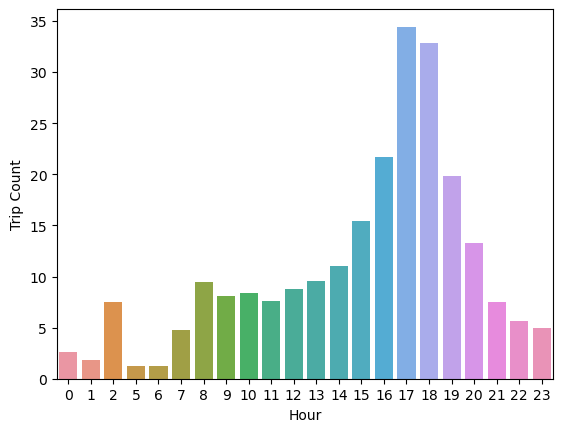

In [23]:
dfSf_Ber=dfSf_Ber.groupby("Hour").agg({"Trip Count": np.mean})
sns.barplot(x=dfSf_Ber.index, y=dfSf_Ber["Trip Count"])

In [24]:
print("Saat", dfSf_Ber.sort_values("Trip Count")[:1].index[0], "ortalama",
      np.round(dfSf_Ber["Trip Count"].min(),2), "adet yolcu sayısı ile en fazla koltuk bulma imkanı olan saatir")

Saat 5 ortalama 1.21 adet yolcu sayısı ile en fazla koltuk bulma imkanı olan saatir


#### <font color=red>Haftanın en yoğun günü hangisidir?</font>

In [25]:
import datetime as dt
df['Date'] = pd.to_datetime(df['Date'])
df['weekday'] = df['Date'].dt.day_name()

<Axes: xlabel='weekday', ylabel='Trip Count'>

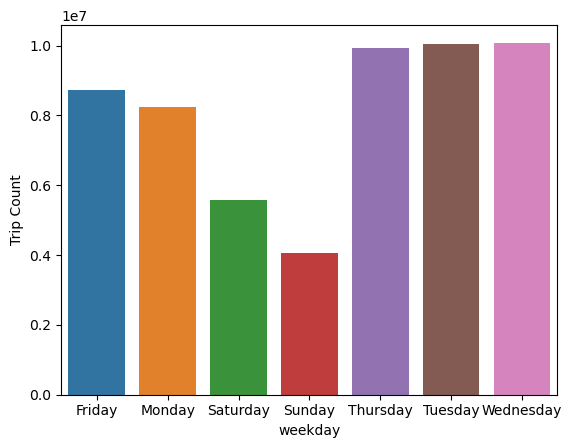

In [26]:
dfw=df.groupby("weekday").agg({"Trip Count": np.sum})
sns.barplot(x=dfw.index, y=dfw["Trip Count"])

In [27]:
dfw.sort_values("Trip Count", ascending=False).head(1)

,Trip Count
weekday,
Wednesday,10080816


In [28]:
print(dfw.sort_values("Trip Count", ascending=False)[:1].index[0], "Günü",
      dfw["Trip Count"].max(), "adet yolcu sayısı ile toplamda en fazla yolcu taşınan gündür")

Wednesday Günü 10080816 adet yolcu sayısı ile toplamda en fazla yolcu taşınan gündür


#### <font color=red>Kaç kişi BART'ı gece geç saatte alıyor?</font>

In [29]:
dfn=df.groupby("Hour").agg({"Trip Count": np.sum})
dfn[:6]

,Trip Count
Hour,
0,436203
1,97148
2,9068
3,491
4,3015
5,579051


In [30]:
print("Gece 0.00-5.00 saatlerinde toplam ", list(dfn[:6].sum())[0], "adet yolcu seyahat etmiştir")

Gece 0.00-5.00 saatlerinde toplam  1124976 adet yolcu seyahat etmiştir


## Veri Bilimi Soruları

#### <font color=red>Soru A: Her istasyon arasındaki düz çizgi mesafesini hesaplayalım</font>

In [31]:
import math

# İki istasyon arasındaki doğru çizgi mesafesini hesaplama
def compute_distance(row):
    lat1 = row['Origin Latitude']
    lon1 = row['Origin Longitude']
    lat2 = row['Destination Latitude']
    lon2 = row['Destination Longitude']

    # Haversine formülü kullanarak doğru çizgi mesafesini hesaplama
    R = 6371  # Yeryüzünün ortalama yarıçapı (km)
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

# Yeni bir "Distance" sütunu ekleyerek her bir istasyonun diğer istasyonlarla olan doğru çizgi mesafesini hesaplama
df['Distance'] = df.apply(compute_distance, axis=1)

In [32]:
df[["Origin Name", "Destination Name", "Distance"]]

,Origin Name,Destination Name,Distance
0,12th St. Oakland City Center,16th St. Mission,13.703707
1,12th St. Oakland City Center,24th St. Mission,14.116576
2,12th St. Oakland City Center,Ashby,5.490919
3,12th St. Oakland City Center,Montgomery St.,11.517171
4,12th St. Oakland City Center,Powell St.,12.064423
...,...,...,...
10782606,West Oakland,El Cerrito Plaza,10.947550
10782607,West Oakland,Powell St.,10.105173
10782608,West Oakland,Richmond,15.574707
10782609,West Oakland,San Leandro,14.849045


In [34]:
#df.to_csv("Bart_distance.csv")

#### <font color=red>Soru B: Bart'ın herhangi 2 istasyon arasında işe gidip gelen kişi sayısını tahmin edebilecek bir model oluşturalım</font>

- Buna nasıl yaklaşırsınız?
  <p>Burada Regression modeli kullanılabilir.</p>
- Hangi ek verilere ihtiyacınız olacak?
  <p>Veri setinde kalkış istasyon kodu, varış istasyon kodu, gün ve saat bilgileri input, Trip Count alanı output olarak seçilebilir. Başka ek veriye şimdilik ihtiyaç yoktur.</p>
- Şehir veya Bart yetkililerinin verilerinizi nasıl kullanmasını istersiniz?
  <p>Oluşturulan model bir web sayfasında veya cep telefonu uygulamasında yayımlanabilir. Böylece yetkililer, istasyon, gün ve saat bilgilerini girip tahmini yolcu sayısını bulabilir.</p>

In [1]:
import pandas as pd
df=pd.read_csv("Bart_distance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10782611 entries, 0 to 10782610
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Date                   object 
 2   Hour                   int64  
 3   Origin Station         object 
 4   Destination Station    object 
 5   Trip Count             int64  
 6   Origin Name            object 
 7   Origin Latitude        float64
 8   Origin Longitude       float64
 9   Destination Name       object 
 10  Destination Latitude   float64
 11  Destination Longitude  float64
 12  Route                  object 
 13  weekday                object 
 14  Distance               float64
dtypes: float64(5), int64(3), object(7)
memory usage: 1.2+ GB


In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
le = LabelEncoder()

In [4]:
df["WeekdayN"] = le.fit_transform(df["weekday"])

In [5]:
df["OriginStN"] = le.fit_transform(df["Origin Station"])
df["DestinationStN"] = le.fit_transform(df["Destination Station"])

In [7]:
df.sample(10)

,Unnamed: 0,Date,Hour,Origin Station,Destination Station,Trip Count,Origin Name,Origin Latitude,Origin Longitude,Destination Name,Destination Latitude,Destination Longitude,Route,weekday,Distance,WeekdayN,OriginStN,DestinationStN
6394510,6394510,2022-10-18,22,FRMT,SHAY,2,Fremont,37.557355,-121.976400,South Hayward,37.634800,-122.057551,FRMT-SHAY,Tuesday,11.192591,5,19,43
1023322,1023322,2022-02-22,18,COLS,24TH,2,Coliseum/Oakland Airport,37.754006,-122.197273,24th St. Mission,37.752254,-122.418466,COLS-24TH,Tuesday,19.447585,5,12,3
823568,823568,2022-02-12,23,BALB,ASHB,1,Balboa Park,37.721981,-122.447414,Ashby,37.853024,-122.269780,BALB-ASHB,Saturday,21.353903,2,6,5
4134609,4134609,2022-07-13,5,24TH,BALB,2,24th St. Mission,37.752254,-122.418466,Balboa Park,37.721981,-122.447414,24TH-BALB,Wednesday,4.220361,6,3,6
5686780,5686780,2022-09-19,10,DALY,SSAN,1,Daly City,37.706121,-122.469081,South San Francisco,37.664174,-122.444116,DALY-SSAN,Monday,5.155701,1,14,44
1395665,1395665,2022-03-11,19,RICH,EMBR,1,Richmond,37.936887,-122.353165,Embarcadero,37.792976,-122.396742,RICH-EMBR,Friday,16.453052,0,38,18
6269369,6269369,2022-10-13,14,BERY,RICH,1,NaN,NaN,NaN,Richmond,37.936887,-122.353165,BERY-RICH,Thursday,NaN,4,8,38
1332811,1332811,2022-03-09,8,SBRN,COLM,2,San Bruno,37.637753,-122.416038,Colma,37.684638,-122.466233,SBRN-COLM,Wednesday,6.833896,6,41,11
4903023,4903023,2022-08-16,9,RICH,19TH,2,Richmond,37.936887,-122.353165,19th St. Oakland,37.807870,-122.269029,RICH-19TH,Tuesday,16.135289,5,38,2
5802209,5802209,2022-09-23,19,COLS,12TH,1,Coliseum/Oakland Airport,37.754006,-122.197273,12th St. Oakland City Center,37.803664,-122.271604,COLS-12TH,Friday,8.553673,0,12,0


In [8]:
dfN=df[["OriginStN", "DestinationStN", "Hour", "WeekdayN", "Trip Count", 
        "Origin Latitude", "Origin Longitude", "Destination Latitude", "Destination Longitude"]]

In [9]:
dfN.sample(10)

,OriginStN,DestinationStN,Hour,WeekdayN,Trip Count,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude
5866114,2,16,19,1,10,37.807870,-122.269029,37.925655,-122.317269
2934941,22,24,19,4,1,37.670399,-122.087967,37.797484,-122.265609
8429301,10,39,22,4,2,37.779528,-122.413756,37.844601,-122.251793
3463380,21,42,6,1,1,37.732921,-122.434092,37.616035,-122.392612
1964216,8,25,17,6,1,NaN,NaN,37.828415,-122.267227
5907472,30,10,12,6,3,38.003275,-122.024597,37.779528,-122.413756
1806457,40,24,15,6,8,37.722619,-122.161311,37.797484,-122.265609
6564326,0,39,7,6,1,37.803664,-122.271604,37.844601,-122.251793
4078499,21,26,15,3,2,37.732921,-122.434092,37.599787,-122.386660
2374307,5,18,9,1,36,37.853024,-122.269780,37.792976,-122.396742


In [10]:
dfN.to_csv("BART_distanceN.csv")

In [11]:
x=df[["OriginStN", "DestinationStN", "Hour", "WeekdayN"]]
y=df[["Trip Count"]]
x.shape, y.shape

((10782611, 4), (10782611, 1))

In [4]:
#x=pd.get_dummies(x, drop_first=True)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


def algo_test(x,y):
        #Bütün modelleri tanımlıyorum
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
        ab=AdaBoostRegressor()
        rf=RandomForestRegressor()
       
        
        algos=[L,R,Lass,E,ETR,GBR,kn,dt,xgb,ab,rf]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','Extra Tree','Gradient Boosting',
                    'KNeighbors','Decision Tree','XGBRegressor', 'AdaBoost', 'Random Forest']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        #Hata ve doğruluk oranlarını bir tablo haline getirmek için bir dataframe oluşturuyorum
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
        
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))
        
            

        #result adlı tabloya doğruluk ve hata oranlarımı yerleştiriyorum
        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
       #oluşturduğum result tablosunu doğruluk oranına (r2_score) göre sıralayıp dönüyor
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

In [17]:
algo_test(x,y)

,R_Squared,RMSE,MAE
Decision Tree,0.820185,4.189381,1.878891
Random Forest,0.820130,4.190025,1.879348
Extra Tree,0.820126,4.190071,1.879194
KNeighbors,0.786723,4.562561,2.045569
XGBRegressor,0.644154,5.893431,2.870752
Gradient Boosting,0.247300,8.571323,4.046115
AdaBoost,0.010469,9.827694,5.659802
Ridge,0.004703,9.856287,4.932879
Linear,0.004703,9.856287,4.932879
ElasticNet,0.003905,9.860238,4.930707


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [19]:
X=scaler.fit_transform(x)

In [20]:
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=.4,random_state=42)

In [21]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error

2024-03-26 13:58:29.924348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model=Sequential()
model.add(Dense(120, activation="relu"))
model.add(Dense(80, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")

2024-03-26 13:58:34.664859: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=10, verbose=1) 

Epoch 1/10
50544/50544 [==============================] - 173s 3ms/step - loss: 77.1757 - val_loss: 80.5073
Epoch 2/10
50544/50544 [==============================] - 173s 3ms/step - loss: 70.0017 - val_loss: 64.5559
Epoch 3/10
50544/50544 [==============================] - 170s 3ms/step - loss: 60.9382 - val_loss: 49.4594
Epoch 4/10
50544/50544 [==============================] - 160s 3ms/step - loss: 53.9775 - val_loss: 57.0888
Epoch 5/10
50544/50544 [==============================] - 160s 3ms/step - loss: 52.0924 - val_loss: 45.7811
Epoch 6/10
50544/50544 [==============================] - 176s 3ms/step - loss: 52.6588 - val_loss: 52.9273
Epoch 7/10
50544/50544 [==============================] - 176s 3ms/step - loss: 48.3924 - val_loss: 52.2754
Epoch 8/10
50544/50544 [==============================] - 164s 3ms/step - loss: 46.8247 - val_loss: 55.7697
Epoch 9/10
50544/50544 [==============================] - 203s 4ms/step - loss: 45.6021 - val_loss: 52.1735
Epoch 10/10
50544/50544 [===

In [27]:
tahmin=model.predict(x_test)

134783/134783 [==============================] - 202s 1ms/step


In [28]:
r2_score(y_test, tahmin)

0.6070178745457802

In [29]:
mean_squared_error(y_test, tahmin) ** .5

6.201215773965645

In [30]:
loss_f=pd.DataFrame(history.history) 

<Axes: >

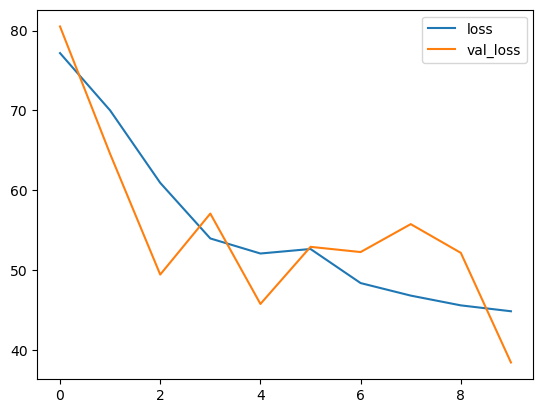

In [31]:
loss_f.plot()

## Sonuç

Bu projede BART Hattına ait transfer verilerine dayanarak bazı sorulara yanıt aranmış ve bir sorunun çözümü olarak derin öğrenme modeli geliştirilmiştir.